# LAB 7 - RANDOM FORESTS AND BOOSTING

This lab is comprised of 4 parts:

- 1. CART Baseline

- 2. Random Forests (basic model and cross-validation)

- 3. Gradient Boosted Trees (basic model and cross-validation)

- 4. Final Comparison

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
ctr = pd.read_csv("CTR.csv")
ctr.info()
ctr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6057 entries, 0 to 6056
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CTR            6057 non-null   float64
 1   titleWords     6057 non-null   int64  
 2   adWords        6057 non-null   int64  
 3   depth          6057 non-null   int64  
 4   position       6057 non-null   int64  
 5   advCTR         6057 non-null   float64
 6   advCTRInPos    6057 non-null   float64
 7   queryCTR       6057 non-null   float64
 8   queryCTRInPos  6057 non-null   float64
 9   gender         6057 non-null   object 
 10  age            6057 non-null   object 
dtypes: float64(5), int64(4), object(2)
memory usage: 520.6+ KB


,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,8,17,1,1,0.0136,0.0153,0.0000,0.0000,male,0-12
1,0.0000,9,19,3,3,0.0199,0.0088,0.0394,0.0125,male,25-30
2,0.0675,6,30,2,1,0.0825,0.1002,0.0200,0.0256,female,13-18
3,0.0000,5,19,3,2,0.0116,0.0090,0.0042,0.0017,female,25-30
4,0.0000,10,22,1,1,0.0186,0.0284,0.0294,0.0431,female,0-12


In [ ]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

## 1. CART BASELINE

### Decision Tree Regressor with CV

We will use a standard decision tree to establish a reference against which to evaluate the ensemble models

#### 1.0 Train test split

In [ ]:
from sklearn.model_selection import train_test_split

y = ctr['CTR']
X = pd.get_dummies(ctr.drop(['CTR'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape

((4239, 18), (1818, 18))

#### 1.1 Define the grid values and perform the Grid Search Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)

### Note that the line below is important. It ensures that the training data is split into
### five folds randomly. Recall what we've seen in the discussion slides that by default,
### GridSearchCV will split the training data without shuffling. 
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
### by setting random_state as a fixed number, we ensure that each time the GridSearchCV splits data, 
### we get the same split.
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
dtr_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeRegressor(min_samples_leaf=5,
                                             min_samples_split=20,
                                             random_state=88),
             param_grid={'ccp_alpha': array([0.0e+00, 2.0e-05, 4.0e-05, 6.0e-05, 8.0e-05, 1.0e-04, 1.2e-04,
       1.4e-04, 1.6e-04, 1.8e-04, 2.0e-04, 2.2e-04, 2.4e-04, 2.6e-04,
       2.8e-04, 3.0e-04, 3.2e-04, 3.4e-04, 3.6e-04, 3.8e-04, 4.0e-04,
       4.2e-04, 4.4e-04, 4.6e-04, 4.8e-04, 5.0e-04, 5.2e-04, 5.4e-04,
       5.6e-04, 5.8e-04, 6.0e-04, 6.2e-04, 6.4e-04, 6.6e-04, 6.8e-04,
       7.0e-04, 7.2e-04, 7.4e-04, 7.6e-04, 7.8e-04, 8.0e-04, 8.2e-04,
       8.4e-04, 8.6e-04, 8.8e-04, 9.0e-04, 9.2e-04, 9.4e-04, 9.6e-04,
       9.8e-04, 1.0e-03])},
             scoring='r2')

#### 1.2 Select the best hyperparameter

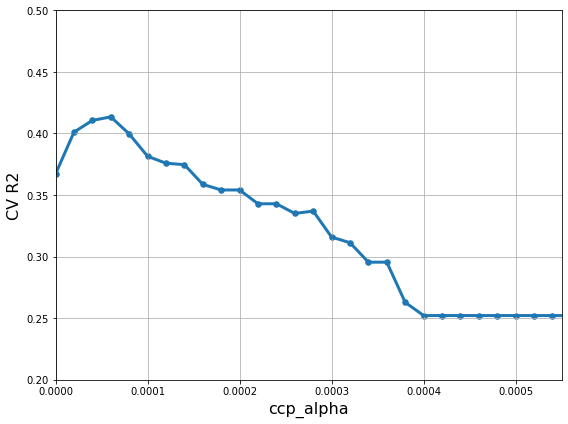

In [ ]:
ccp_alpha = dtr_cv.cv_results_['param_ccp_alpha'].data
R2_scores = dtr_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(ccp_alpha, R2_scores, s=30)
plt.plot(ccp_alpha, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([0, 0.00055])
plt.ylim([0.2, 0.5])

plt.tight_layout()
plt.show()

In [ ]:
print('Best ccp_alpha', dtr_cv.best_params_)

Best ccp_alpha {'ccp_alpha': 6.000000000000001e-05}


#### 1.3 Evaluate the model performance (trained on the entire training set)

In [ ]:
# Model Evaluation
print('Cross-validated R2:', round(dtr_cv.best_score_, 5))
print('OSR2:', round(OSR2(dtr_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.41349
OSR2: 0.4819


## 2. RANDOM FORESTS

### 2.1 Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=5, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=2)
# Note: you can change the verbose parameter to control how much training progress is printed.
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators=500,
                      random_state=88, verbose=2)

In [ ]:
rf.verbose = False

print('OSR2:', round(OSR2(rf, X_test, y_test, y_train), 5))

OSR2: 0.56419


#### Feature Importance

In [ ]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*rf.feature_importances_}).round(1)

,Feature,Importance score
0,titleWords,3.8
1,adWords,3.4
2,depth,2.3
3,position,2.2
4,advCTR,23.5
5,advCTRInPos,32.7
6,queryCTR,10.0
7,queryCTRInPos,18.0
8,gender_female,0.8
9,gender_male,0.5


### 2.2 Random Forest Regressor with CV

#### 2.2.1 Define the grid values and perform the Grid Search Cross-Validation

NOTE: This cross-validation takes 4 minutes to run on my laptop.

In [ ]:
## using GridSearchCV to find best max_features:

import time

grid_values = {'max_features': np.linspace(1,18,18, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

rf2 = RandomForestRegressor() 
# Note: here we set verbose=2 to keep track of the progress (the running time) of the cross validation. 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   1.0s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   1.0s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.9s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.9s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.9s
[CV] max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88, total=   1.1s
[CV] max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88, total=   1.1s
[CV] max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88

[CV]  max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88, total=   3.4s
[CV] max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88, total=   3.1s
[CV] max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88, total=   3.2s
[CV] max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88, total=   3.2s
[CV] max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88, total=   3.3s
[CV] max_features=12, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=12, min_samples_leaf=5, n_estimators=500, random_state=88, total=   3.5s
[CV] max_features=12, min_samples_leaf=5, n_estimators=500, ran

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.3min finished


time: 259.89 s


####  2.2.2 Select the best hyperparameter

(0.3, 0.6)

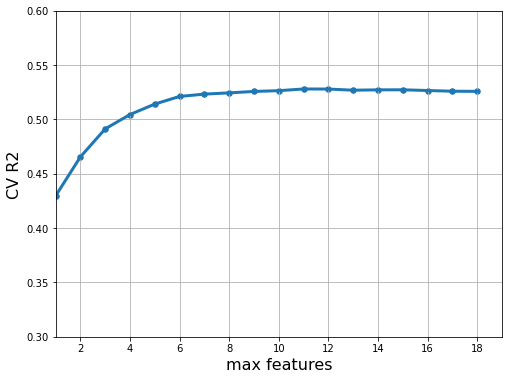

In [ ]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 19])
plt.ylim([0.3, 0.6])

In [ ]:
print(rf_cv.best_params_)

{'max_features': 11, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


#### 2.2.3 Evaluate the model performance (trained on the entire training set)

In [ ]:
print('Cross-validated R2:', round(rf_cv.best_score_, 5))
print('OSR2:', round(OSR2(rf_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.52795
OSR2: 0.56398


#### 2.2.4 Feature Importance

In [ ]:
pd.DataFrame({'Feature' : X_train.columns,  
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)


,Feature,Importance score
0,titleWords,3.7
1,adWords,3.1
2,depth,1.7
3,position,0.8
4,advCTR,20.3
5,advCTRInPos,39.1
6,queryCTR,8.5
7,queryCTRInPos,19.7
8,gender_female,0.6
9,gender_male,0.4


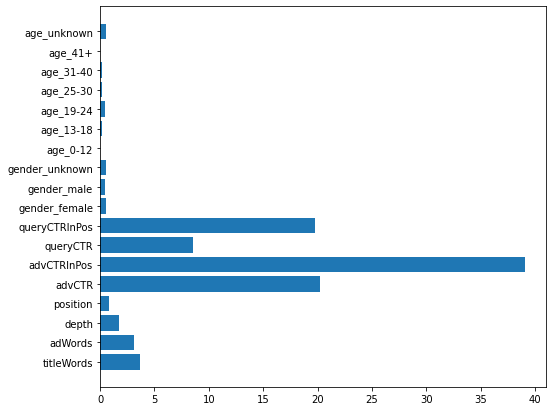

In [ ]:
plt.figure(figsize=(8,7))
plt.barh(X_train.columns, 100*rf_cv.best_estimator_.feature_importances_)
plt.show()

## 3. GRADIENT BOOSTED TREES

### 3.1 Gradient Boosting Regressor

Controlling tree size using `max_leaf_nodes` vs. `max_depth`: https://scikit-learn.org/stable/modules/ensemble.html#controlling-the-tree-size

We choose use `max_leaf_nodes` as our primary parameter to control the size of the tree: we set `max_depth` to a large value so that it does not interfere with the construction of the trees. 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=2000, learning_rate= 0.001, max_leaf_nodes=3,
                                max_depth=10, min_samples_leaf=10, random_state=88, verbose=1) 
gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0060           12.22s
         2           0.0060           11.41s
         3           0.0060           11.03s
         4           0.0060           10.81s
         5           0.0060           10.56s
         6           0.0060           10.49s
         7           0.0060           10.61s
         8           0.0060           10.54s
         9           0.0060           10.33s
        10           0.0060           10.19s
        20           0.0059            9.53s
        30           0.0059            9.31s
        40           0.0059            9.10s
        50           0.0058            9.09s
        60           0.0058            8.93s
        70           0.0058            8.75s
        80           0.0057            8.65s
        90           0.0057            8.53s
       100           0.0057            8.43s
       200           0.0054            7.61s
       300           0.0051            7.16s
       40

GradientBoostingRegressor(learning_rate=0.001, max_depth=10, max_leaf_nodes=3,
                          min_samples_leaf=10, n_estimators=2000,
                          random_state=88, verbose=1)

In [ ]:
print('OSR2:', round(OSR2(gbr, X_test, y_test, y_train), 5))

OSR2: 0.4388


Note that the OSR2 of the above gbr model is not very good. It is because the model is quite sensitive to hypterparameters. We will learn how to find the best parameters using cross-validation and see the improvement one could get from choosing the best hyperparameters.

### 3.2 Gradient Boosting Regressor with CV

Note that if you use the `GridSearchCV` function directly with the gbr as the classifier, the run-time is super long (e.g., more than 30 hours). The reason is that the naive implement of `GridSearchCV` does not take into account the special additive nature of the Boosting models. 

For example, if you need to decide what is the best number of trees to include in your model and you would like to try values from 1 to 10000. The naive implementation of `GridSearchCV` would train 10000 different gbr models. However, a much more efficient way is to train a model with 10000 trees, and only subset a subset of them in your model when needed. This trick allows us to reduce the training time of gbr_cv to less than 2 hours. 

If you use the `caret` package in `R`, they have implemented this efficient algorithm, but there is not a good counterpart in `Python` `sklearn`. Therefore, below is the code that manually implemented by the GSI. It is a good example to demonstrate the flexibility you can achieve if you go beyond the built-in packages. The code takes 2 hour to run for the current hyperparameter grid, where 

`n_estimators = np.linspace(500, 75*500, 75, dtype='int32')
max_leaf_nodes = np.linspace(2, 10, 9, dtype='int32')  `

However, you can change these values to a small subset to reduce the run-time.

#### 1.1 Split the training data into 5 folds for cross validation

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True, random_state=88)
kfold_index = [] 
for index in kf.split(X_train):
    kfold_index.append(index)
# Each element of kfold_index is in the form of (kfold_index, kfold_index)

#### 1.2 Define the grid and initialize the output array

In [ ]:
# Define the grid (## I am using a subset of the original grid, to reduce the running time)
n_estimators = np.linspace(500, 75*500, 75, dtype='int32')
max_leaf_nodes = np.linspace(2, 10, 9, dtype='int32')  

In [ ]:
# Initialize the output array
R2_array = np.zeros([len(n_estimators),len(max_leaf_nodes)])
R2_array[:]=np.nan
RMSE_array = np.zeros([len(n_estimators),len(max_leaf_nodes)])
RMSE_array[:]=np.nan
MAE_array = np.zeros([len(n_estimators),len(max_leaf_nodes)])
MAE_array[:]=np.nan
print(R2_array.shape)

(75, 9)


#### 1.4 Manually implement the k-fold cv for the gbr model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import time
start = time.time()
for itr in range(len(max_leaf_nodes)):
    depth = max_leaf_nodes[itr]
    print('iter % s, max_depth: %s' % (itr, depth))
    #------begin the 5-fold cross validation ------
    R2_array_cv = np.zeros([len(n_estimators),5])
    R2_array_cv[:]=np.nan
    RMSE_array_cv = np.zeros([len(n_estimators),5])
    RMSE_array_cv[:]=np.nan
    MAE_array_cv = np.zeros([len(n_estimators),5])
    MAE_array_cv[:]=np.nan
    for i in range(5):
        train_idx, val_idx = kfold_index[i]
        X_train_cv = X_train.iloc[train_idx]
        y_train_cv = y_train.iloc[train_idx]
        X_val_cv = X_train.iloc[val_idx]
        y_val_cv = y_train.iloc[val_idx]
        print('   fold-%s, training set size %s, validation set size %s' %(i, len(train_idx), len(val_idx)))
        #------ Given each training set and validation set, train a gbr model with the maximum n_estimators
        gbr2 = GradientBoostingRegressor(n_estimators = n_estimators[-1], learning_rate = 0.005, max_depth = 20,
                                         max_leaf_nodes=depth, min_samples_leaf=10,random_state=99,verbose=0)
        gbr2.fit(X_train_cv,y_train_cv)
        j=0
        idx=[]
        r2_lst=[]
        rmse_lst=[]
        mae_lst=[]
        for y_staged_pred in gbr2.staged_predict(X_val_cv): #gbr staged_predict: predict the result based on the subtree
            r2= pearsonr(y_staged_pred, y_val_cv)[0] ** 2
            rmse = mean_squared_error(y_val_cv, y_staged_pred, squared=False)
            mae = mean_absolute_error(y_val_cv, y_staged_pred)
            if j % 500 == 0:
                idx.append(j)
                r2_lst.append(r2)
                rmse_lst.append(rmse)
                mae_lst.append(mae)
            j+=1
        R2_array_cv[:,i]=r2_lst
        RMSE_array_cv[:,i]=rmse_lst
        MAE_array_cv[:,i]=mae_lst
        print('        cv fold-%s, time-ellapsed: %.2f' %(i,time.time()-start))
    R2_array[:,itr]=np.average(R2_array_cv,axis = 1)
    RMSE_array[:,itr]=np.average(RMSE_array_cv,axis = 1)
    MAE_array[:,itr]=np.average(MAE_array_cv,axis = 1)

iter 0, max_depth: 2
   fold-0, training set size 3391, validation set size 848
        cv fold-0, time-ellapsed: 109.03
   fold-1, training set size 3391, validation set size 848
        cv fold-1, time-ellapsed: 220.15
   fold-2, training set size 3391, validation set size 848
        cv fold-2, time-ellapsed: 331.08
   fold-3, training set size 3391, validation set size 848
        cv fold-3, time-ellapsed: 440.39
   fold-4, training set size 3392, validation set size 847
        cv fold-4, time-ellapsed: 549.18
iter 1, max_depth: 3
   fold-0, training set size 3391, validation set size 848
        cv fold-0, time-ellapsed: 674.29
   fold-1, training set size 3391, validation set size 848
        cv fold-1, time-ellapsed: 798.76
   fold-2, training set size 3391, validation set size 848
        cv fold-2, time-ellapsed: 931.63
   fold-3, training set size 3391, validation set size 848
        cv fold-3, time-ellapsed: 1061.58
   fold-4, training set size 3392, validation set size 84

#### 1.5 Visualize the performance metrics (R^2).

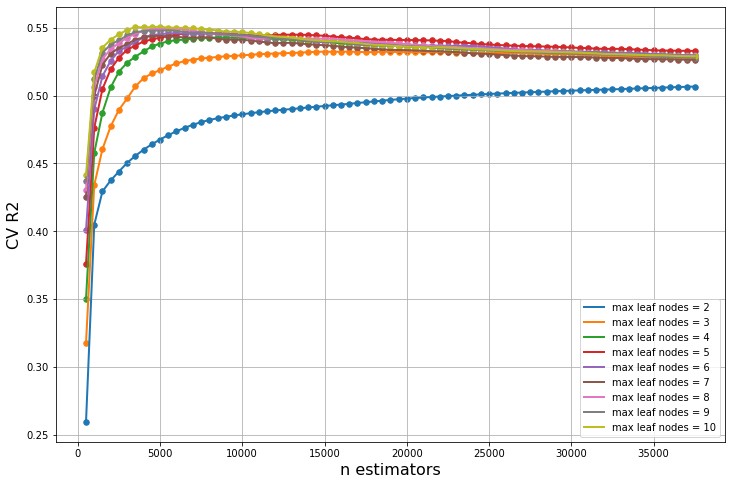

In [ ]:
plt.figure(figsize=(12, 8))
plt.xlabel('n estimators', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.grid(True, which='both')

N = len(max_leaf_nodes)
M = len(n_estimators)
for i in range(N):
    plt.scatter(n_estimators, R2_array[:,i], s=30)
    plt.plot(n_estimators, R2_array[:,i], linewidth=2,
             label='max leaf nodes = '+str(max_leaf_nodes[i]))
plt.legend(loc='lower right')
plt.show()

In [ ]:
best_model_index = np.argmax(R2_array)
row_index = best_model_index//R2_array.shape[1]
col_index = best_model_index % R2_array.shape[1]
best_n_estimators = n_estimators[row_index]
best_max_leaf_nodes = max_leaf_nodes[col_index]
print('Best Model: n_estimator = %s, max_leaf_nodes = %s' %(best_n_estimators, best_max_leaf_nodes))

Best Model: n_estimator = 5000, max_leaf_nodes = 10


#### 1.6 Train the model with the best hyperparameters on the full training data.

In [ ]:
gbr_cv = GradientBoostingRegressor(n_estimators = best_n_estimators, learning_rate = 0.005, max_depth = 20,
                                max_leaf_nodes=best_max_leaf_nodes, min_samples_leaf=10,random_state=99,verbose=0)
gbr_cv.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.005, max_depth=20, max_leaf_nodes=10,
                          min_samples_leaf=10, n_estimators=5000,
                          random_state=99)

#### 1.7 Evaluate the full model

In [ ]:
print('Cross-validated R2:', round(R2_array[row_index, col_index], 5))
print('OSR2:', round(OSR2(gbr_cv, X_test, y_test, y_train), 5))

Cross-validated R2: 0.55082
OSR2: 0.53333


In [ ]:
pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*gbr_cv.feature_importances_}).round(1)

,Feature,Importance score
0,titleWords,2.0
1,adWords,3.0
2,depth,2.5
3,position,0.4
4,advCTR,13.2
5,advCTRInPos,49.5
6,queryCTR,6.4
7,queryCTRInPos,21.3
8,gender_female,0.4
9,gender_male,0.1


## 4. Final Comparison

### 4.1 Linear Regression Baseline

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)

### 4.2 Comparison Table

In [ ]:
comparison_data = {'Linear Regression': ['{:.3f}'.format(OSR2(lr, X_test, y_test, y_train)),
                                         '{:.4f}'.format(mean_squared_error(y_test, lr.predict(X_test))),
                                         '{:.3f}'.format(mean_absolute_error(y_test, lr.predict(X_test)))],
                   'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, X_test, y_test, y_train)),
                                               '{:.4f}'.format(mean_squared_error(y_test, dtr_cv.predict(X_test))),
                                               '{:.3f}'.format(mean_absolute_error(y_test, dtr_cv.predict(X_test)))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, X_test, y_test, y_train)),
                                     '{:.4f}'.format(mean_squared_error(y_test, rf_cv.predict(X_test))),
                                     '{:.3f}'.format(mean_absolute_error(y_test, rf_cv.predict(X_test)))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(gbr_cv, X_test, y_test, y_train)),
                                              '{:.4f}'.format(mean_squared_error(y_test, gbr_cv.predict(X_test))),
                                              '{:.3f}'.format(mean_absolute_error(y_test, gbr_cv.predict(X_test)))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Out-of-sample MSE', 'Out-of-sample MAE'])
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,Linear Regression,Decision Tree Regressor,Random Forest,Gradient Boosted Trees
OSR2,0.488,0.436,0.556,0.533
Out-of-sample MSE,0.0028,0.0030,0.0024,0.0025
Out-of-sample MAE,0.032,0.033,0.029,0.030


Let's look at MAE restricted to CTR above and below 10%

In [ ]:
y_test_above = y_test[y_test >0.1]
X_test_above = X_test[y_test >0.1]

y_test_below = y_test[y_test <=0.1]
X_test_below = X_test[y_test <=0.1]

MAE_rf_above = mean_absolute_error(y_test_above, rf_cv.predict(X_test_above))
MAE_rf_below = mean_absolute_error(y_test_below, rf_cv.predict(X_test_below))

MAE_gbr_above = mean_absolute_error(y_test_above, gbr_cv.predict(X_test_above))
MAE_gbr_below = mean_absolute_error(y_test_below, gbr_cv.predict(X_test_below))

In [ ]:
print('Random Forest Out-of-sample MAE for CTR above 10%:', round(MAE_rf_above, 3))
print('Random Forest Out-of-sample MAE for CTR below 10%:', round(MAE_rf_below, 3))

print('\nGradient Boosted Trees Out-of-sample MAE for CTR above 10%:', round(MAE_gbr_above, 3))
print('Gradient Boosted Trees Out-of-sample MAE for CTR below 10%:', round(MAE_gbr_below, 3))

Random Forest Out-of-sample MAE for CTR above 10%: 0.076
Random Forest Out-of-sample MAE for CTR below 10%: 0.021

Gradient Boosted Trees Out-of-sample MAE for CTR above 10%: 0.079
Gradient Boosted Trees Out-of-sample MAE for CTR below 10%: 0.021
